- srun --time=10:00:00 --gres=gpu:1 --pty bash
- nvidia-smi

In [3]:
import sys
print(sys.executable)

c:\Users\mayeu\.venvs\venvPFE\Scripts\python.exe


In [4]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.5.1+cpu
None
False


In [5]:
import numpy as np
import pandas as pd
import gcsfs
import xarray as xr
import scipy

## Generate datas

First we need to generate the data by simplifying the era5 grid with the corresponding keys: 'geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'sim_time'.

These keys have dimensions (37, 256, 128). 37 corresponds to the pressure level in the atmosphere and (256, 128) corresponds to the coordinates on the earth. 256 is a simplified dimension for longitude and 128 is a simplified dimension for latitude.

We're going to generate data on a simplified model by reducing the dimension by around 8. We therefore have this dimension for our simplified model: (5, 32, 16)

For all key, we will generate data based on the density of these 5 pressure levels ([0, 10, 20, 30, 36]).

In [7]:
input_variables =['geopotential', 
                    'specific_humidity','temperature',
                    'u_component_of_wind',
                    'v_component_of_wind',
                    'specific_cloud_ice_water_content',
                    'specific_cloud_liquid_water_content']

forcing_variables = ['sea_ice_cover', 'sea_surface_temperature']

longitude_nodes=64
latitude_nodes=32

longitude_nodes_original = 256
latitude_nodes_original = 128
level_original = [i for i in range(37)]
level = [0, 10, 20, 30, 36]
dtime = '2020-02-14T00'

demo_start_time = '2020-02-14'
demo_end_time = '2020-02-18'
data_inner_steps = 6

path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'

In [5]:
gcs = gcsfs.GCSFileSystem(token='anon')
full_era5 = xr.open_zarr(gcs.get_mapper(path), chunks=None)

In [6]:
from import_era5 import data_generation

regridded, sliced_era5 = data_generation(data = full_era5,
    demo_start_time = '2020-02-14',
    demo_end_time = '2020-02-18',
    data_inner_steps = data_inner_steps, 
    input_variables = input_variables,
    forcing_variables = forcing_variables,
    longitude_nodes = longitude_nodes,
    latitude_nodes = latitude_nodes,
    level = level)

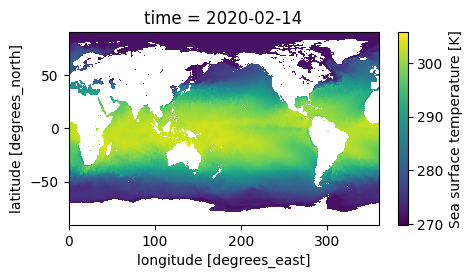

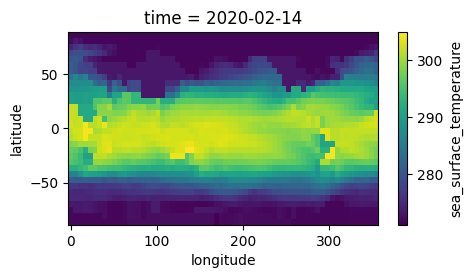

In [7]:
dtime = '2020-02-14T00'
sliced_dtime_era5 = sliced_era5.sel(time=dtime).compute()
regridded_dtime = regridded.sel(time=dtime).compute()

sliced_dtime_era5.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);
regridded_dtime.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);

### Normalization of input features

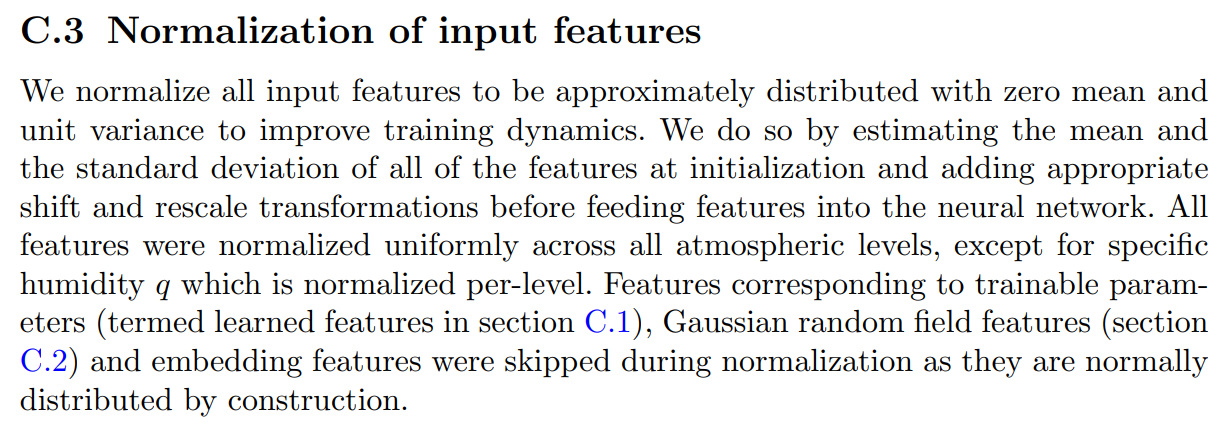

First of all, we normalise the data in order to obtain reduced centred data. And we do so for all the other features. The normalised data is then transferred to encoder (Lounis)

In [8]:
def normalize_z_score(array):
    mean_val = array.mean(dim=array.dims)
    std_val = array.std(dim=array.dims)
    return (array - mean_val) / std_val

In [9]:
normalized_dataset = regridded.copy()

for var in regridded.data_vars:
    dims = regridded[var].dims
    normalized_dataset[var] = normalize_z_score(regridded[var])

## Encoder

### Lounis part

In [ ]:
!git clone https://github.com/mylrcd/neuralgcmPFE.git
%pip install -e neuralgcmPFE

import sys
sys.path.append("c:/Users/mayeu/SynologyDrive/DossiersMayeul/Mes Documents/TSP/3A/PFE/NeuralGCM/quickstart/neuralgcmPFE")

from neuralgcmPFE import neuralgcm

model_name = 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

import pickle

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
    ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

fatal: destination path 'neuralgcmPFE' already exists and is not an empty directory.


Obtaining file:///C:/Users/mayeu/SynologyDrive/DossiersMayeul/Mes%20Documents/TSP/3A/PFE/NeuralGCM/combinedModel/neuralgcmPFE
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for neuralgcm (pyproject.toml): started
  Building editable for neuralgcm (pyproject.toml): finished with status 'done'
  Created wheel for neuralgcm: filename=neuralgcm-1.0.0-0.editable-py3-none-any.whl size=11522 sha256=6421ff1369284162f530ed15fbf3f816573628c7c28c681cd3a7328551f2fef7
  Stored in directory: C:\Users\mayeu\AppData\Local\Temp\pip-ephem-whee


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\mayeu\AppData\Local\Temp\ipykernel_47568\3665349786.py:14: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  ckpt = pickle.load(f)


: 

In [12]:
regridded_original, sliced_era5_original = data_generation(data = full_era5,
    demo_start_time = '2020-02-14',
    demo_end_time = '2020-02-18',
    data_inner_steps = data_inner_steps, 
    input_variables = input_variables,
    forcing_variables = forcing_variables,
    longitude_nodes = longitude_nodes_original,
    latitude_nodes = latitude_nodes_original,
    level = level_original)

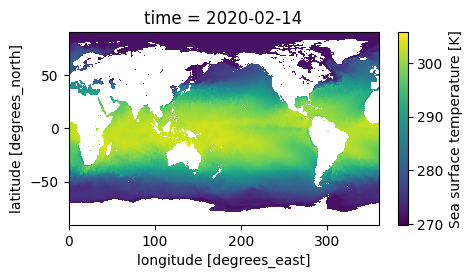

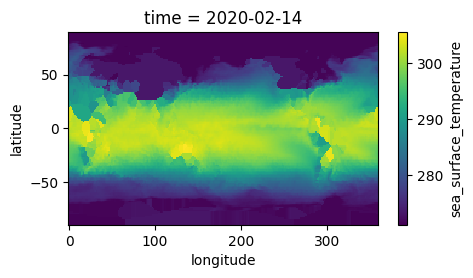

In [14]:
dtime = '2020-02-14T00'
sliced_dtime_era5_original = sliced_era5_original.sel(time=dtime).compute()
regridded_dtime_original = regridded_original.sel(time=dtime).compute()

sliced_dtime_era5_original.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);
regridded_dtime_original.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);

In [15]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

In [15]:
""" initial_state_xr = regridded.isel(time=0)

input_forcings = initial_state_xr.isel(level=0)
input_forcings = input_forcings.expand_dims("level", axis=0)
#input_forcings = regridded
input_forcings = {var: input_forcings[forcing_variables][var].values for var in input_forcings[forcing_variables].data_vars}
inputs = {var: initial_state_xr[input_variables][var].values for var in initial_state_xr[input_variables].data_vars}

sim_time = np.array(189248.050944)
inputs['sim_time'] = sim_time
input_forcings['sim_time'] = sim_time 

for key, value in input_forcings.items():
    print(f"{key}: {value.shape}")
    
dim_1 = 256
dim_2 = 128
dim_0 = 36

inputs = {
    "geopotential": np.random.rand(dim_0, dim_1, dim_2),
    "specific_humidity": np.random.rand(dim_0, dim_1, dim_2), 
    "temperature": np.random.rand(dim_0, dim_1, dim_2),
    "u_component_of_wind": np.random.rand(dim_0, dim_1, dim_2), 
    "v_component_of_wind": np.random.rand(dim_0, dim_1, dim_2), 
    "specific_cloud_ice_water_content": np.random.rand(dim_0, dim_1, dim_2),
    "specific_cloud_liquid_water_content": np.random.rand(dim_0, dim_1, dim_2), 
    "sim_time": np.random.rand(),  # scalar value ()
}

input_forcings = {
    "sea_ice_cover": np.random.rand(1, dim_1, dim_2),  # (1, 512, 128)
    "sea_surface_temperature": np.random.rand(1, dim_1, dim_2),  # (1, 512, 128)
    "sim_time": np.random.rand(),  # scalar value ()
}"""

In [16]:
import numpy as np
import jax
rng_key = jax.random.PRNGKey(42)

states_divergence = np.empty((5, 32, 256, 128), dtype='float32') 
states_log_surface_pressure = np.empty((5, 32, 256, 128), dtype='float32') 
states_vorticity = np.empty((5, 32, 256, 128), dtype='float32') 
states_temperature_deviation = np.empty((5, 32, 256, 128), dtype='float32') 

for i in range(5):
    inputs_original = model.inputs_from_xarray(regridded_original.isel(time=i))
    input_forcings_original = model.forcings_from_xarray(regridded_original.isel(time=i))
    state = model.encode(inputs_original, input_forcings_original, rng_key)
    states_divergence[i] = state.state.divergence[ :, :, :128]
    states_log_surface_pressure[i] = state.state.log_surface_pressure[ :, :, :128]
    states_vorticity [i] = state.state.vorticity[ :, :, :128]
    states_temperature_deviation[i] = state.state.temperature_variation[ :, :, :128]

In [17]:
states_divergence = np.transpose(states_divergence, (1, 0, 2, 3))
states_vorticity = np.transpose(states_vorticity, (1, 0, 2, 3))
states_temperature_deviation = np.transpose(states_temperature_deviation, (1, 0, 2, 3))
states_log_surface_pressure = np.transpose(states_log_surface_pressure, (1, 0, 2, 3))

In [18]:
regridded_original_encode = regridded_original.isel(time=slice(0, 5))
regridded_original_encode = regridded_original_encode.isel(level=slice(0, 32))
regridded_original_encode = regridded_original_encode.isel(time=slice(0, 5))
regridded_original_encode['divergence'] = xr.DataArray(states_divergence, coords=regridded_original_encode.coords, dims=regridded_original_encode.dims)
regridded_original_encode['vorticity'] = xr.DataArray(states_vorticity, coords=regridded_original_encode.coords, dims=regridded_original_encode.dims)
regridded_original_encode['log_surface_pressure'] = xr.DataArray(states_log_surface_pressure, coords=regridded_original_encode.coords, dims=regridded_original_encode.dims)
regridded_original_encode['temperature_deviation'] = xr.DataArray(states_temperature_deviation, coords=regridded_original_encode.coords, dims=regridded_original_encode.dims)

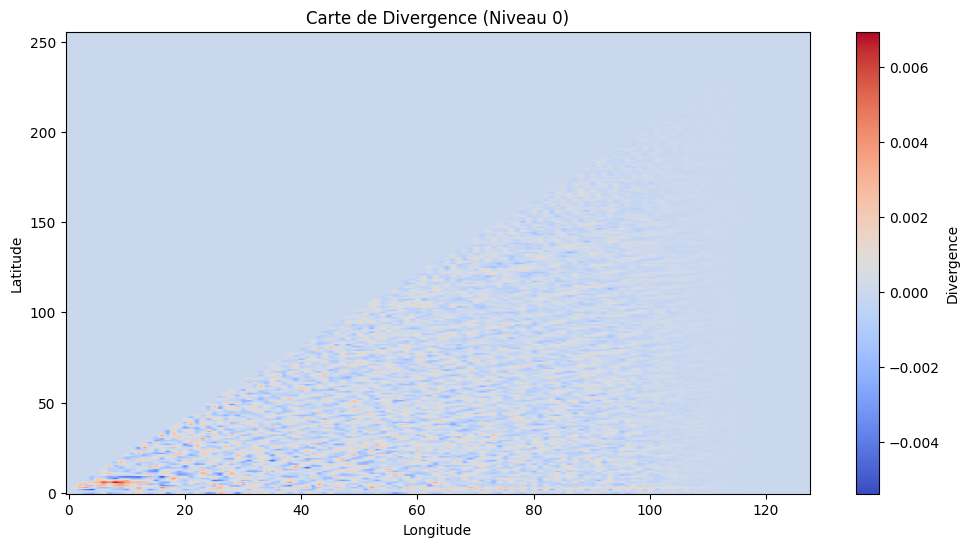

In [19]:
divergence_map = regridded_original_encode.isel(time=0).isel(level=0).divergence.values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(divergence_map, origin='lower', cmap='coolwarm', aspect='auto')
plt.colorbar(label="Divergence")
plt.title("Carte de Divergence (Niveau 0)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [13]:
level_original = [i for i in range(32)]

In [14]:
from import_era5 import data_rescale

level = [0, 1, 2, 3, 4]


regridded_encode = data_rescale(data = regridded_original_encode,
    longitude_nodes = longitude_nodes,
    latitude_nodes = latitude_nodes,
    level = level_original)

In [16]:
regridded_original_encode.to_netcdf("data/full_encoded_dataa.nc")
regridded_encode.to_netcdf("data/encoded_dataa_64x32.nc")

In [6]:
regridded_original_encode = xr.open_dataset("data/full_encoded_data.nc")
regridded_encode = xr.open_dataset("data/encoded_data.nc")

In [25]:
regridded_original_encode

<xarray.Dataset> Size: 232MB
Dimensions:                              (longitude: 256, latitude: 128,
                                          level: 32, time: 5)
Coordinates:
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
  * level                                (level) int32 128B 1 2 3 ... 850 875
  * time                                 (time) datetime64[ns] 40B 2020-02-14...
Data variables: (12/13)
    divergence                           (level, time, longitude, latitude) float32 21MB ...
    vorticity                            (level, time, longitude, latitude) float32 21MB ...
    log_surface_pressure                 (level, time, longitude, latitude) float32 21MB ...
    temperature_deviation                (level, time, longitude, latitude) float32 21MB ...
    sea_ice_cover                        (time, longitude, latitude) float32 655kB ...
    sea_surface_temperature              (time, longitude, latitude) float32 655kB ...
    ...                                   ...
    specific_humidity                    (time, level, longitude, latitude) float32 21MB ...
    temperature                          (time, level, longitude, latitude) float32 21MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 21MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 21MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 21MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 21MB ...

In [26]:
regridded_encode

<xarray.Dataset> Size: 232MB
Dimensions:                              (longitude: 256, latitude: 128,
                                          level: 32, time: 5)
Coordinates:
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
  * level                                (level) int32 128B 1 2 3 ... 850 875
  * time                                 (time) datetime64[ns] 40B 2020-02-14...
Data variables: (12/13)
    divergence                           (level, time, longitude, latitude) float32 21MB ...
    vorticity                            (level, time, longitude, latitude) float32 21MB ...
    log_surface_pressure                 (level, time, longitude, latitude) float32 21MB ...
    temperature_deviation                (level, time, longitude, latitude) float32 21MB ...
    sea_ice_cover                        (time, longitude, latitude) float32 655kB ...
    sea_surface_temperature              (time, longitude, latitude) float32 655kB ...
    ...                                   ...
    specific_humidity                    (time, level, longitude, latitude) float32 21MB ...
    temperature                          (time, level, longitude, latitude) float32 21MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 21MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 21MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 21MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 21MB ...